# Práctica 4: Detección de características 

## Participantes:
- Gerardo León Quintana
- Susana Suárez Mendoza

In [3]:
import cv2 as cv
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import math
from main_functions import apply_sift, align_image

## Ejercicio 1: 

Desarrolle una aplicación que permita:

a. A través de la interfaz modificar los parámetros del detector de características SIFT.

b. Seleccionar un área de interés en una imagen de elección una imagen de naturaleza médica y una imagen telemétrica. 

c. Buscar esa área de interés (recuádrela en rojo) dentro de diferentes versiones de la imagen de partida (con cambios de traslación, escala y rotación) [NOTA: Estos cambios se pueden acometer con un editor de imágenes o con el trabajo hecho en prácticas previas]. Altere mediante la interfaz las configuraciones de parámetros para mejorar la detección. 

d. Pruebe a hacer lo mismo que en el apartado c. con diferentes grados de deformación de la imagen. [NOTA: Estos cambios se pueden acometer con un editor de imágenes o con el trabajo hecho en prácticas previas].

(OPICIONAL)
A partir del detector de características “corrija” la imagen alterada para que se alinee con la imagen fuente. 

NOTA 1: Si no encuentra el área de interés la aplicación debería notificarlo. 

NOTA 2: Puede preprocesar la imagen con alguna técnica (suavizado, contrastado,…) si lo estima necesario.

In [4]:
img = cv.imread('./images/telemetricas/alcorcon_sur_40.3392046_-3.8385131.jpg')
img_orig = img.copy()

# Parámetros de SIFT por defecto
nfeatures = 500
nOctaveLayers = 3
contrastThreshold = 0.04
edgeThreshold = 10
sigma = 1.6

coordinates = []
drawing = False 
start_point = None

def nothing(x):
    pass

def draw_shape(event, x, y, flags, param):
    global start_point, drawing, coordinates

    color = (0, 0, 255)
    thickness = 2

    if event == cv.EVENT_LBUTTONDOWN:
        drawing = True
        start_point = (x, y)
        

    # Dibujar la figura mientras se mueve el mouse
    elif event == cv.EVENT_MOUSEMOVE:
        if drawing:
            img_copy = img.copy()
            cv.rectangle(img_copy, start_point, (x, y), color, thickness)
            cv.imshow('image', img_copy)

    # Dibujar la figura al soltar el click
    elif event == cv.EVENT_LBUTTONUP:
        drawing = False
        end_point = (x, y)
        cv.rectangle(img, start_point, end_point, color, thickness)
        coordinates.append((start_point, end_point))
        cv.imshow('image', img)
        extract_interest_area(start_point, end_point, img_orig)


def extract_interest_area(start_point, end_point, img):
    x1, y1 = start_point
    x2, y2 = end_point
    if x1 < x2 and y1 < y2:
        interest_area = img[y1:y2, x1:x2]
    else:
        interest_area = img[y2:y1, x2:x1]
    cv.imwrite('interest_area.png', interest_area)



cv.namedWindow('image')
cv.setMouseCallback('image', draw_shape)
cv.createTrackbar('Features', 'image', nfeatures, 800, nothing)
cv.createTrackbar('Layers', 'image', nOctaveLayers, 10, nothing)
cv.createTrackbar('Contrast', 'image', int(contrastThreshold*100), 100, nothing)
cv.createTrackbar('Edge', 'image', edgeThreshold, 100, nothing)
cv.createTrackbar('Sigma', 'image', int(sigma*10), 100, nothing)
cv.createTrackbar('Matches', 'image', 10, 100, nothing)

cv.imshow('image', img)

while True:

    nfeatures = cv.getTrackbarPos('Features', 'image')
    nOctaveLayers = cv.getTrackbarPos('Layers', 'image')
    contrastThreshold = cv.getTrackbarPos('Contrast', 'image') / 100
    edgeThreshold = cv.getTrackbarPos('Edge', 'image')
    sigma = cv.getTrackbarPos('Sigma', 'image') / 10
    n = cv.getTrackbarPos('Matches', 'image')
    
    key = cv.waitKey(1) & 0xFF
    if key == 27:
        break

    elif key == ord('r'):
        img = img_orig.copy()
        coordinates = []
        os.remove('interest_area.png')

        cv.imshow('image', img)
    
    elif key == ord('d'):
        sift = cv.SIFT_create(nfeatures=nfeatures, nOctaveLayers=nOctaveLayers, contrastThreshold=contrastThreshold, edgeThreshold=edgeThreshold, sigma=sigma)
        if os.path.exists('interest_area.png'):
            founded_matches = apply_sift(sift, img_orig, n)
            cv.imshow('Traslacion', founded_matches[0])
            cv.imshow('Rotacion', founded_matches[1])
            cv.imshow('Escala', founded_matches[2])
            cv.imshow('Barril', founded_matches[3])
            cv.imshow('Cojin', founded_matches[4])
            cv.imshow('Ruido', founded_matches[5])
        else:
            print('No se ha seleccionado un área de interés')
            # TODO: mensaje por ventana P2
    
    elif key == ord('a'):
        aligned_img, img_transformed = align_image(img_orig , nfeatures, nOctaveLayers, contrastThreshold, edgeThreshold, sigma, n)
        if aligned_img is not None and img_transformed is not None:
            cv.imshow('Transformed Image', img_transformed)
            cv.imshow('Aligned Image', aligned_img)
        else:
            #TODO: mensaje por ventana P2
            print('No se han encontrado coincidencias')

    elif key == 8:

        try:
            cv.destroyWindow('Traslacion')
            cv.destroyWindow('Rotacion')
            cv.destroyWindow('Escala')
            cv.destroyWindow('Barril')
            cv.destroyWindow('Cojin')
            cv.destroyWindow('Ruido')
            
            img = img_orig.copy()
            coordinates = []
            os.remove('interest_area.png')

            cv.imshow('image', img)
        except:
            cv.destroyWindow('Transformed Image')
            cv.destroyWindow('Aligned Image')
            

cv.destroyAllWindows()

In [ ]:
# TODO: NOTIFICACIÓNES
# TODO: MANUAL

# TODO: README
# TODO: TUMORES SALE COMO EL CULO, MIRA A VER SI TU PUEDES AJUSTAR HIPERPARÁMETROS u OTRA MANERA
# TODO: falta hacer una carpeta con las imagenes de nuestras caras (que lo dijo JC Reyes)
"""
 1. No mezclar glioma con pituitario pq entonces peor
 2. Seleccionas el area - le das a d (tarda un poco)- salen las gráficas
 3. Como mehor me da es seleccionando el rectángulo en vertical y no en horizontal
"""

## Opcional:

Se cuenta con una serie de imágenes médicas obtenidas mediante resonancia magnética de un paciente diagnosticado con un tumor cerebral. En este proceso, se procede a la selección del área correspondiente al tumor, para posteriormente buscar su representación en las distintas imágenes proporcionadas. El objetivo de esta búsqueda es identificar y analizar la presencia del tumor en las diferentes secuencias de imágenes disponibles.

In [40]:
route = f'./images/Tumores/tumor_glioma/Tr-gl_0516.jpg'
#folders = [ 'no_tumor', 'tumor_glioma', 'tumor_pituitario']
folders = [ 'no_tumor', 'tumor_glioma']
#folders = [ 'no_tumor', 'tumor_pituitario']
#route = f'./images/Tumores/{folders[1]}/Tr-pi_0570.jpg'

In [44]:
def search_tumors(img_orig, folders, n=6, min_matches=6, max_distance=300):

    founded_matches = []
    route_files_with_tumors = []
    coordinates = []

    sift = cv.SIFT_create(nfeatures=100, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=0.6)
    interest_area = cv.imread('tumor.png', cv.IMREAD_GRAYSCALE)
    keypoints1, descriptors1 = sift.detectAndCompute(interest_area, None)

    for folder in folders:
        for file in os.listdir(f'./images/Tumores/{folder}'):
            img = cv.imread(f'./images/Tumores/{folder}/{file}', cv.IMREAD_GRAYSCALE)
            try:
                keypoints2, descriptors2 = sift.detectAndCompute(img, None)

                if descriptors2 is None or len(descriptors2) == 0:
                    continue
            
                bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
                matches = bf.match(descriptors1, descriptors2)
                matches = sorted(matches, key=lambda x: x.distance)

                good_matches = [m for m in matches if m.distance < max_distance]
                image_coordinates = []

                if len(good_matches) >= min_matches:
                    for m in good_matches:
                        x, y = int(keypoints2[m.trainIdx].pt[0]), int(keypoints2[m.trainIdx].pt[1])
                        x1, y1 = max(0, x - 15), max(0, y - 15)
                        x2, y2 = min(img.shape[1], x + 15), min(img.shape[0], y + 15)
                        image_coordinates.append((x1, y1, x2, y2))

                    coordinates.append(image_coordinates)

                    img_matches = cv.drawMatches(
                        interest_area, keypoints1, img, keypoints2,
                        good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                    )
                    founded_matches.append(cv.cvtColor(img_matches, cv.COLOR_BGR2RGB))
                    route_files_with_tumors.append(f'./images/Tumores/{folder}/{file}')

            except:
                print(f"No se ha podido procesar la imagen {file}")
    
    return founded_matches, route_files_with_tumors, coordinates

In [45]:
def show_detected_tumors(images, coordinates, columns=3):
    rows = math.ceil(len(images) / columns)

    fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 5))
    axes = axes.flatten()

    for idx, img_path in enumerate(images):
        img = cv.imread(img_path)
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        for (x1, y1, x2, y2) in coordinates[idx]:
            cv.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
        axes[idx].imshow(img_rgb)
        axes[idx].axis('off')
        axes[idx].set_title(f"{img_path}")

    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


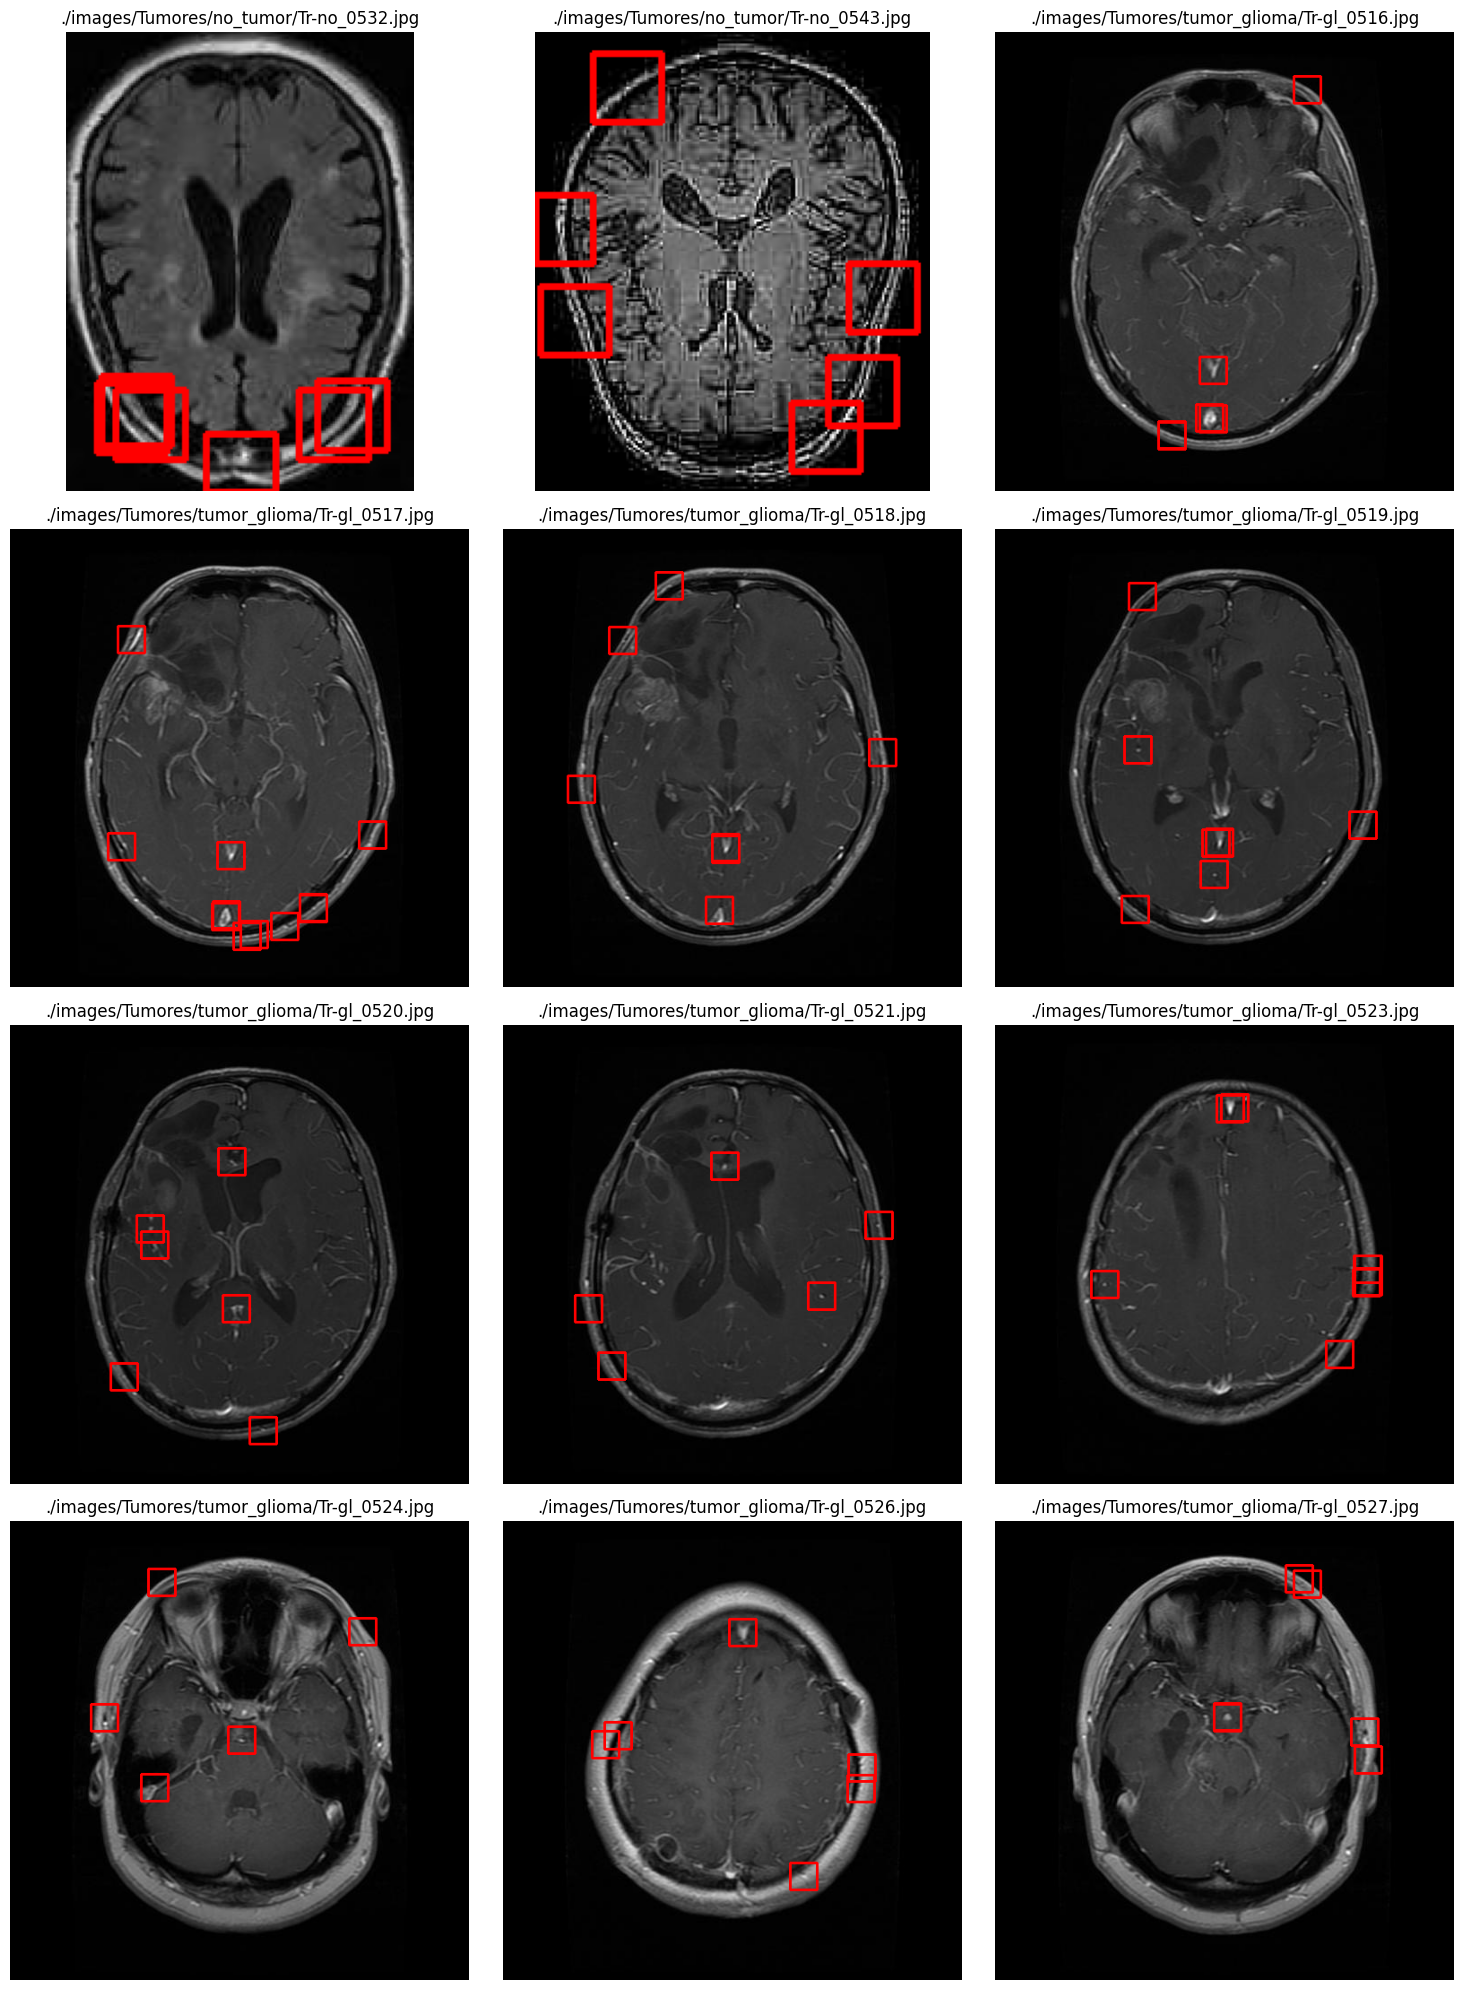

In [48]:
img = cv.imread(route)
img_orig = img.copy()

coordinates = []
drawing = False 
start_point = None

def draw_shape(event, x, y, flags, param):
    global start_point, drawing, coordinates

    color = (0, 0, 255)
    thickness = 2

    if event == cv.EVENT_LBUTTONDOWN:
        drawing = True
        start_point = (x, y)
        

    # Dibujar la figura mientras se mueve el mouse
    elif event == cv.EVENT_MOUSEMOVE:
        if drawing:
            img_copy = img.copy()
            cv.rectangle(img_copy, start_point, (x, y), color, thickness)
            cv.imshow('image', img_copy)

    # Dibujar la figura al soltar el click
    elif event == cv.EVENT_LBUTTONUP:
        drawing = False
        end_point = (x, y)
        cv.rectangle(img, start_point, end_point, color, thickness)
        coordinates.append((start_point, end_point))
        cv.imshow('image', img)
        extract_interest_area(start_point, end_point, img_orig)


def extract_interest_area(start_point, end_point, img):
    x1, y1 = start_point
    x2, y2 = end_point
    if x1 < x2 and y1 < y2:
        interest_area = img[y1:y2, x1:x2]
    else:
        interest_area = img[y2:y1, x2:x1]
    cv.imwrite('tumor.png', interest_area)


cv.namedWindow('image')
cv.setMouseCallback('image', draw_shape)

cv.imshow('image', img)

while True:  
    key = cv.waitKey(1) & 0xFF
    if key == 27:
        break
    elif key == ord('d'):
        if os.path.exists('tumor.png'):
            founded_matches, files, coordinates = search_tumors(img_orig, folders, 10)
            show_detected_tumors(files, coordinates)
        else:
            print('No se ha seleccionado un área de interés')
            # TODO: mensaje por ventana P2
    
    elif key == 8:
        img = img_orig.copy()
        coordinates = []
        os.remove('tumor.png')
        cv.imshow('image', img)

cv.destroyAllWindows()